# How Convolution layer works?


- 기수: 13기

- 이름: 김선기

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

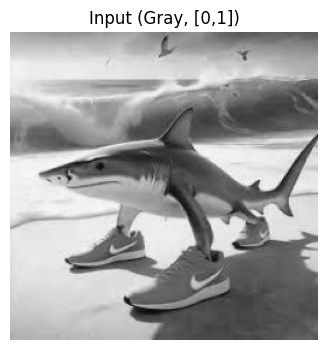

In [4]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="./tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')


**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [5]:
import numpy as np

def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W)
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    # padding=0, stride=1 조건으로 구현
    padding = 0
    # padding=0 이므로 원본 이미지를 그대로 사용합니다.
    # padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1

    ## Todo ##
    # 1. 이미지와 커널의 높이, 너비 추출
    H, W = image.shape
    kH, kW = kernel.shape

    # 2. 출력 이미지의 높이, 너비 계산
    outH = H - kH + 1
    outW = W - kW + 1

    # 3. 결과를 저장할 0으로 채워진 배열 생성
    out = np.zeros((outH, outW))

    # 4. 루프를 돌며 합성곱 연산 수행
    # 출력 이미지의 모든 픽셀 위치(y, x)에 대해 반복
    for y in range(outH):
        for x in range(outW):
            # 원본 이미지에서 커널과 겹치는 부분(window)을 잘라냄
            window = image[y:y + kH, x:x + kW]

            # window와 커널의 요소별 곱셈(element-wise multiplication) 후
            # 모든 값을 더해서 출력 위치에 저장
            out[y, x] = np.sum(window * kernel)

    ###########
    return out

**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

특징 추출기로서의 커널, 슬라이딩 윈도우 방식, 요소별 곱셈 및 합산을 구현했기 때문이다.
1. CNN에서는 커널은 세로선, 가로선, 특정 색상 조합 등 이미지의 특정 특성을 감지하는 역할을 한다.
2. 슬라이딩 윈도우 연산. CNN은 커널을 이미지의 좌측 상단부터 우측 하단까지 한 칸씩 이동시키며 전체 이미지를 훓는다. 코드의 이중 for 문은 이 방식을 구현한 것이다.
3. 요소별 곱셈과 합산. 이미지의 특정 영역 위로 커널이 겹쳐졌을 때, CNN은 두 행렬의 같은 위치에 있는 값끼리 곱한 후 그 총합을 구한다. 이는 code에서 np.sum(window*kernel)로 구현되어 있다.

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [6]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [7]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화

    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


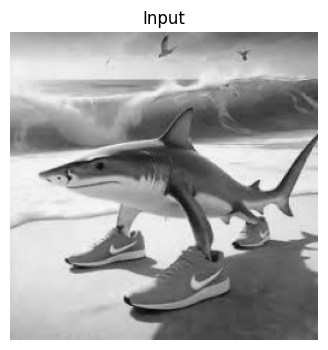

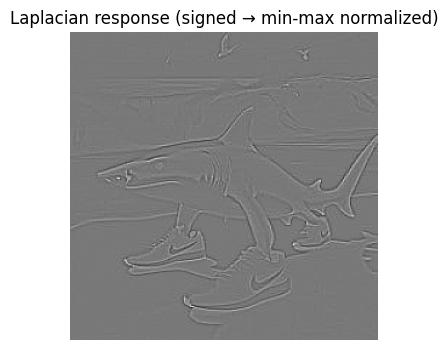

=== Sobel Vertical ===


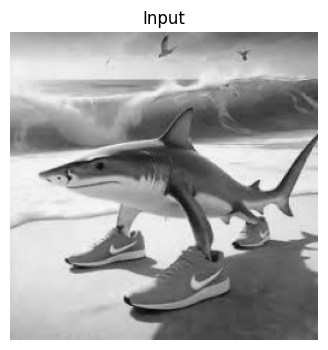

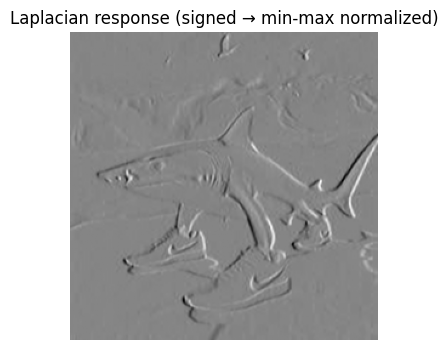

=== Sobel Horizontal ===


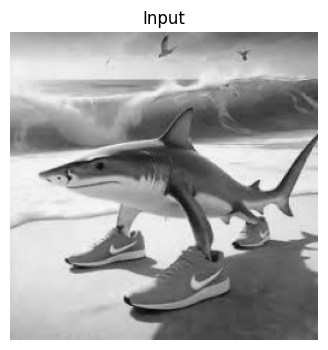

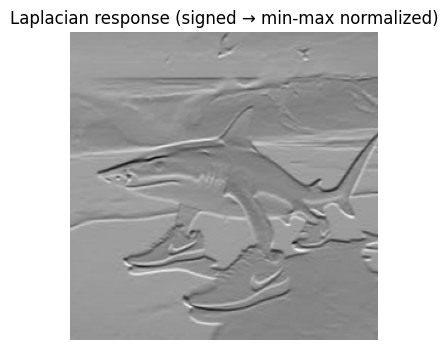

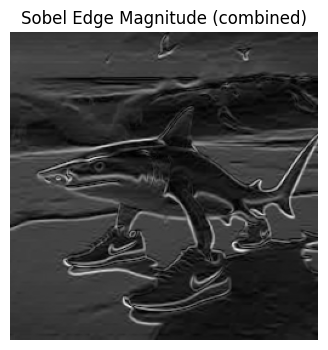

In [8]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 12.2MB/s]


In [10]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1 # BasicBlock은 채널 수를 확장하지 않으므로 1

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        super(BasicBlock, self).__init__()

        # 3x3 합성곱 레이어 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 합성곱 레이어 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut Connection (입력과 출력의 차원 또는 채널 수가 다를 경우 조정)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x # shortcut을 위해 원본 입력 저장

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(identity) # shortcut connection 더하기
        out = F.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, block: nn.Module = BasicBlock, num_blocks: list = [2, 2, 2, 2], num_classes: int = 10) -> None:
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # CIFAR10 용 수정: kernel=3, stride=1, padding=1. 초기 MaxPool 제거
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # ResNet의 4개 레이어
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Adaptive Average Pooling과 Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block: nn.Module, out_channels: int, num_blocks: int, stride: int) -> nn.Sequential:
        # 첫 번째 블록에서만 stride를 적용하여 다운샘플링 수행
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1) # Batch size에 맞춰 flatten
        out = self.fc(out)
        return out

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [12]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [00:42<00:00, 11.83it/s]


Epoch 1/20, Loss: 1.256725984454155


Epoch 2/20: 100%|██████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 2/20, Loss: 0.7294788524508476


Epoch 3/20: 100%|██████████| 500/500 [00:42<00:00, 11.83it/s]


Epoch 3/20, Loss: 0.5146357328295708


Epoch 4/20: 100%|██████████| 500/500 [00:42<00:00, 11.70it/s]


Epoch 4/20, Loss: 0.37804051437973973


Epoch 5/20: 100%|██████████| 500/500 [00:42<00:00, 11.65it/s]


Epoch 5/20, Loss: 0.2784896372705698


Epoch 6/20: 100%|██████████| 500/500 [00:43<00:00, 11.59it/s]


Epoch 6/20, Loss: 0.18788951357454062


Epoch 7/20: 100%|██████████| 500/500 [00:43<00:00, 11.52it/s]


Epoch 7/20, Loss: 0.13524942043423652


Epoch 8/20: 100%|██████████| 500/500 [00:43<00:00, 11.53it/s]


Epoch 8/20, Loss: 0.08847694210521877


Epoch 9/20: 100%|██████████| 500/500 [00:43<00:00, 11.54it/s]


Epoch 9/20, Loss: 0.07853825713321566


Epoch 10/20: 100%|██████████| 500/500 [00:43<00:00, 11.53it/s]


Epoch 10/20, Loss: 0.06424766919016837


Epoch 11/20: 100%|██████████| 500/500 [00:43<00:00, 11.51it/s]


Epoch 11/20, Loss: 0.04394007232971489


Epoch 12/20: 100%|██████████| 500/500 [00:43<00:00, 11.52it/s]


Epoch 12/20, Loss: 0.03752577433828264


Epoch 13/20: 100%|██████████| 500/500 [00:43<00:00, 11.50it/s]


Epoch 13/20, Loss: 0.027073498273734002


Epoch 14/20: 100%|██████████| 500/500 [00:43<00:00, 11.52it/s]


Epoch 14/20, Loss: 0.021007541864644735


Epoch 15/20: 100%|██████████| 500/500 [00:43<00:00, 11.50it/s]


Epoch 15/20, Loss: 0.015696614686166867


Epoch 16/20: 100%|██████████| 500/500 [00:43<00:00, 11.52it/s]


Epoch 16/20, Loss: 0.010484449869720264


Epoch 17/20: 100%|██████████| 500/500 [00:43<00:00, 11.50it/s]


Epoch 17/20, Loss: 0.004028792875353247


Epoch 18/20: 100%|██████████| 500/500 [00:43<00:00, 11.51it/s]


Epoch 18/20, Loss: 0.0013166843627986963


Epoch 19/20: 100%|██████████| 500/500 [00:43<00:00, 11.48it/s]


Epoch 19/20, Loss: 0.000773860369954491


Epoch 20/20: 100%|██████████| 500/500 [00:43<00:00, 11.48it/s]

Epoch 20/20, Loss: 0.0006883677290461491


In [13]:
test(model, testloader, device)

Test Accuracy: 85.89%


85.89

:**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

Original ResNet18은 224x224 크기의 ImageNet 이미지에 최적화되어 있음. 이를 32x32 크기의 작은 CIFAR10 이미지에 그대로 적용하면, 네트워크 초반에 정보가 너무 급격하게 손실되어 모델 성능이 저하됨. 따라서 다음과 같이 구조를 변경해야 함.

Original ResNet18: kernel_size=7, stride=2를 사용하여 입력 이미지 크기를 빠르게 절반으로 줄어듦. 이는 큰 이미지에서 효율적

CIFAR10 ResNet18: kernel_size=3, stride=1로 변경

수정 이유: 32x32 이미지에 원본 설정을 적용하면 너무 많은 공간 정보가 초반에 사라짐. 더 작은 커널과 stride를 사용해 정보 손실을 최소화하고, 이미지의 세부적인 특징을 보존한 채로 다음 레이어로 전달하기 위함

Original ResNet18: conv1 다음에 MaxPool 레이어를 두어 이미지 크기를 다시 절반으로 줄임

CIFAR10 ResNet18: 이 MaxPool 레이어를 완전히 제거

수정 이유: conv1과 마찬가지로, 작은 이미지에 대한 과도한 초기 다운샘플링을 막기 위함임. 대신, 다운샘플링은 네트워크의 더 깊은 부분(layer2, layer3 등)에서 점진적으로 수행하도록 하여, 모델이 저차원의 특징을 충분히 학습한 후 이미지 크기를 줄이도록 만듦.